In [1]:
import wandb
import IPython
from IPython.display import Image, display
import torch
import gc
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import sys
sys.path.append('..')
try:
    from acdc.tracr_task.utils import (
        get_all_tracr_things,
        get_tracr_model_input_and_tl_model,
    )
except Exception as e:
    print(f"Could not import `tracr` because {e}; the rest of the file should work but you cannot use the tracr tasks")
from acdc.docstring.utils import get_all_docstring_things
from acdc.acdc_utils import (
    make_nd_dict,
    reset_network,
    shuffle_tensor,
    cleanup,
    ct,
    TorchIndex,
    Edge,
    EdgeType,
)  # these introduce several important classes !!!

from acdc.TLACDCCorrespondence import TLACDCCorrespondence
from acdc.TLACDCInterpNode import TLACDCInterpNode
from acdc.TLACDCExperiment import TLACDCExperiment

from acdc.acdc_utils import (
    kl_divergence,
)
from acdc.ioi.utils import (
    get_all_ioi_things,
    get_gpt2_small,
)
from acdc.induction.utils import (
    get_all_induction_things,
    get_validation_data,
    get_good_induction_candidates,
    get_mask_repeat_candidates,
)
from acdc.knowledge.utils import(
    get_all_knowledge_things
)
from acdc.greaterthan.utils import get_all_greaterthan_things
from acdc.acdc_graphics import (
    build_colorscheme,
    show,
)
import argparse

torch.autograd.set_grad_enabled(False)

/newdisk3/yunzhi/miniconda3/envs/circuit/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Could not import `tracr` because No module named 'tracr'; the rest of the file should work but you cannot use the tracr tasks


In [2]:
parser = argparse.ArgumentParser(description="Used to launch ACDC runs. Only task and threshold are required")

task_choices = ['ioi', 'docstring', 'induction', 'tracr-reverse', 'tracr-proportion', 'greaterthan','knowledge']
parser.add_argument('--task', type=str, required=True, choices=task_choices, help=f'Choose a task from the available options: {task_choices}')
parser.add_argument('--threshold', type=float, required=True, help='Value for THRESHOLD')
parser.add_argument('--first-cache-cpu', type=str, required=False, default="True", help='Value for FIRST_CACHE_CPU (the old name for the `online_cache`)')
parser.add_argument('--second-cache-cpu', type=str, required=False, default="True", help='Value for SECOND_CACHE_CPU (the old name for the `corrupted_cache`)')
parser.add_argument('--zero-ablation', action='store_true', help='Use zero ablation')
parser.add_argument('--using-wandb', action='store_true', help='Use wandb')
parser.add_argument('--wandb-entity-name', type=str, required=False, default="remix_school-of-rock", help='Value for WANDB_ENTITY_NAME')
parser.add_argument('--wandb-group-name', type=str, required=False, default="default", help='Value for WANDB_GROUP_NAME')
parser.add_argument('--wandb-project-name', type=str, required=False, default="acdc", help='Value for WANDB_PROJECT_NAME')
parser.add_argument('--wandb-run-name', type=str, required=False, default=None, help='Value for WANDB_RUN_NAME')
parser.add_argument("--wandb-dir", type=str, default="/tmp/wandb")
parser.add_argument("--wandb-mode", type=str, default="online")
parser.add_argument('--indices-mode', type=str, default="normal")
parser.add_argument('--names-mode', type=str, default="normal")
parser.add_argument('--device', type=str, default="cuda")
parser.add_argument('--reset-network', type=int, default=0, help="Whether to reset the network we're operating on before running interp on it")
parser.add_argument('--metric', type=str, default="kl_div", help="Which metric to use for the experiment")
parser.add_argument('--torch-num-threads', type=int, default=0, help="How many threads to use for torch (0=all)")
parser.add_argument('--seed', type=int, default=1234)
parser.add_argument("--max-num-epochs",type=int, default=100_000)
parser.add_argument('--single-step', action='store_true', help='Use single step, mostly for testing')
parser.add_argument("--abs-value-threshold", action='store_true', help='Use the absolute value of the result to check threshold')

# We are in a notebook
# you can put the command you would like to run as the ... in r"""..."""
args = parser.parse_args(
    [line.strip() for line in r"""--task=knowledge\
--zero-ablation\
--threshold=0.01\
--indices-mode=reverse\
--first-cache-cpu=False\
--second-cache-cpu=False\
--metric=match_nll\
--device=cuda:1\
--max-num-epochs=100000""".split("\\\n")]
)

# Process args

if args.torch_num_threads > 0:
    torch.set_num_threads(args.torch_num_threads)
torch.manual_seed(args.seed)

TASK = args.task
if args.first_cache_cpu is None: # manage default
    ONLINE_CACHE_CPU = True
elif args.first_cache_cpu.lower() == "false":
    ONLINE_CACHE_CPU = False
elif args.first_cache_cpu.lower() == "true":
    ONLINE_CACHE_CPU = True
else: 
    raise ValueError(f"first_cache_cpu must be either True or False, got {args.first_cache_cpu}")
if args.second_cache_cpu is None:
    CORRUPTED_CACHE_CPU = True
elif args.second_cache_cpu.lower() == "false":
    CORRUPTED_CACHE_CPU = False
elif args.second_cache_cpu.lower() == "true":
    CORRUPTED_CACHE_CPU = True
else:
    raise ValueError(f"second_cache_cpu must be either True or False, got {args.second_cache_cpu}")
THRESHOLD = args.threshold  # only used if >= 0.0
ZERO_ABLATION = True if args.zero_ablation else False
USING_WANDB = True if args.using_wandb else False
WANDB_ENTITY_NAME = args.wandb_entity_name
WANDB_PROJECT_NAME = args.wandb_project_name
WANDB_RUN_NAME = args.wandb_run_name
WANDB_GROUP_NAME = args.wandb_group_name
INDICES_MODE = args.indices_mode
NAMES_MODE = args.names_mode
DEVICE = args.device
RESET_NETWORK = args.reset_network
SINGLE_STEP = True if args.single_step else False

<h2>Setup Task</h2>

In [3]:

second_metric = None  # some tasks only have one metric
use_pos_embed = TASK.startswith("tracr")

if TASK == "ioi":
    num_examples = 100
    things = get_all_ioi_things(
        num_examples=num_examples, device=DEVICE, metric_name=args.metric
    )
elif TASK == "tracr-reverse":
    num_examples = 6
    things = get_all_tracr_things(
        task="reverse",
        metric_name=args.metric,
        num_examples=num_examples,
        device=DEVICE,
    )
elif TASK == "tracr-proportion":
    num_examples = 50
    things = get_all_tracr_things(
        task="proportion",
        metric_name=args.metric,
        num_examples=num_examples,
        device=DEVICE,
    )
elif TASK == "induction":
    num_examples = 10
    seq_len = 300
    things = get_all_induction_things(
        num_examples=num_examples, seq_len=seq_len, device=DEVICE, metric=args.metric
    )
elif TASK == "docstring":
    num_examples = 50
    seq_len = 41
    things = get_all_docstring_things(
        num_examples=num_examples,
        seq_len=seq_len,
        device=DEVICE,
        metric_name=args.metric,
        correct_incorrect_wandb=True,
    )
elif TASK == "greaterthan":
    num_examples = 100
    things = get_all_greaterthan_things(
        num_examples=num_examples, metric_name=args.metric, device=DEVICE
    )
elif TASK == "knowledge":
    num_examples = 12
    things = get_all_knowledge_things(
        num_examples=num_examples, metric_name=args.metric, device=DEVICE,model="gpt2", 
        model_path="/newdisk3/yunzhi/gpt2", 
        data_path="../data",
        relation_name="person_native_language.json",
        index_name="person_native_language.pt",
    )
else:
    raise ValueError(f"Unknown task {TASK}")

Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda:1


In [4]:
validation_metric = things.validation_metric # metric we use (e.g KL divergence)
toks_int_values = things.validation_data # clean data x_i
toks_int_values_other = things.validation_patch_data # corrupted data x_i'
tl_model = things.tl_model # transformerlens model

if RESET_NETWORK:
    reset_network(TASK, DEVICE, tl_model)

In [5]:
tl_model.to_string(toks_int_values)[2]

'<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Dmitry Medvedev speaks the language of Russian'

In [6]:
tl_model.to_string(toks_int_values_other)[2]

'<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Nadezhda Krupskaya speaks the language of Russian'

<h2>Setup ACDC Experiment</h2>

In [7]:
# Make notes for potential wandb run
try:
    with open(__file__, "r") as f:
        notes = f.read()
except:
    notes = "No notes generated, expected when running in an .ipynb file"

tl_model.reset_hooks()

# Save some mem
gc.collect()
torch.cuda.empty_cache()

# Setup wandb if needed
if WANDB_RUN_NAME is None or IPython.get_ipython() is not None:
    WANDB_RUN_NAME = f"{ct()}{'_randomindices' if INDICES_MODE=='random' else ''}_{THRESHOLD}{'_zero' if ZERO_ABLATION else ''}"
else:
    assert WANDB_RUN_NAME is not None, "I want named runs, always"

tl_model.reset_hooks()
exp = TLACDCExperiment(
    model=tl_model,
    threshold=THRESHOLD,
    using_wandb=USING_WANDB,
    wandb_entity_name=WANDB_ENTITY_NAME,
    wandb_project_name=WANDB_PROJECT_NAME,
    wandb_run_name=WANDB_RUN_NAME,
    wandb_group_name=WANDB_GROUP_NAME,
    wandb_notes=notes,
    wandb_dir=args.wandb_dir,
    wandb_mode=args.wandb_mode,
    wandb_config=args,
    zero_ablation=ZERO_ABLATION,
    abs_value_threshold=args.abs_value_threshold,
    ds=toks_int_values,
    ref_ds=toks_int_values_other,
    metric=validation_metric,
    second_metric=second_metric,
    verbose=True,
    indices_mode=INDICES_MODE,
    names_mode=NAMES_MODE,
    corrupted_cache_cpu=CORRUPTED_CACHE_CPU,
    hook_verbose=False,
    online_cache_cpu=ONLINE_CACHE_CPU,
    add_sender_hooks=True,
    use_pos_embed=use_pos_embed,
    add_receiver_hooks=False,
    remove_redundant=False,
    show_full_index=use_pos_embed,
)

/newdisk3/yunzhi/Knowledge-Circuit/notebook/../acdc/TLACDCExperiment.py:139: UserWarning: We shall overwrite the ref_ds with zeros.
  warnings.warn("We shall overwrite the ref_ds with zeros.")


dict_keys(['blocks.11.hook_resid_post', 'blocks.11.hook_mlp_out', 'blocks.11.hook_mlp_in', 'blocks.11.attn.hook_result', 'blocks.11.attn.hook_q', 'blocks.11.hook_q_input', 'blocks.11.attn.hook_k', 'blocks.11.hook_k_input', 'blocks.11.attn.hook_v', 'blocks.11.hook_v_input', 'blocks.10.hook_mlp_out', 'blocks.10.hook_mlp_in', 'blocks.10.attn.hook_result', 'blocks.10.attn.hook_q', 'blocks.10.hook_q_input', 'blocks.10.attn.hook_k', 'blocks.10.hook_k_input', 'blocks.10.attn.hook_v', 'blocks.10.hook_v_input', 'blocks.9.hook_mlp_out', 'blocks.9.hook_mlp_in', 'blocks.9.attn.hook_result', 'blocks.9.attn.hook_q', 'blocks.9.hook_q_input', 'blocks.9.attn.hook_k', 'blocks.9.hook_k_input', 'blocks.9.attn.hook_v', 'blocks.9.hook_v_input', 'blocks.8.hook_mlp_out', 'blocks.8.hook_mlp_in', 'blocks.8.attn.hook_result', 'blocks.8.attn.hook_q', 'blocks.8.hook_q_input', 'blocks.8.attn.hook_k', 'blocks.8.hook_k_input', 'blocks.8.attn.hook_v', 'blocks.8.hook_v_input', 'blocks.7.hook_mlp_out', 'blocks.7.hook_ml

In [8]:
args.max_num_epochs

100000

<h2>Run steps of ACDC: iterate over a NODE in the model's computational graph</h2>
<p>WARNING! This will take a few minutes to run, but there should be rolling nice pictures too : )</p>

No edge 32923
New metric: 0.0

Node: cur_parent=TLACDCInterpNode(blocks.11.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.11.hook_resid_post, [:]))

Metric after removing connection to blocks.11.hook_mlp_out [:] is -0.03632952645421028 (and current metric 0.0)
Result is -0.03632952645421028...so removing connection
No edge 32922

Node: cur_parent=TLACDCInterpNode(blocks.11.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.11.hook_resid_post, [:]))

Metric after removing connection to blocks.11.attn.hook_result [:, :, 0] is -0.10511089116334915 (and current metric -0.03632952645421028)
Result is -0.06878136470913887...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.11.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.11.hook_resid_post, [:]))

Metric after removing connection to blocks.11.attn.hook_result [:, :, 1] is -0.10825259983539581 (and current metric -0.10511089116334915)
Result is -0.0031417086720466614

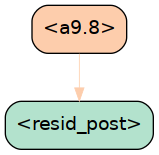

0 --------------------------------------------------
No edge 22366
22366
No edge 22366
New metric: 0.09159860759973526
No edge 22366
No edge 22366
No edge 22366
We moved to  blocks.9.attn.hook_result[:, :, 7]
No edge 22366
No edge 22366
But it's bad
We moved to  blocks.9.attn.hook_result[:, :, 6]
No edge 22366
No edge 22366
But it's bad
We moved to  blocks.9.attn.hook_result[:, :, 5]
No edge 22366
No edge 22366
But it's bad
We moved to  blocks.9.attn.hook_result[:, :, 4]
No edge 22366
No edge 22366
But it's bad
We moved to  blocks.9.attn.hook_result[:, :, 3]
No edge 22366
No edge 22366
But it's bad
We moved to  blocks.9.attn.hook_result[:, :, 2]
No edge 22366
No edge 22366
But it's bad
We moved to  blocks.9.attn.hook_result[:, :, 1]
No edge 22366
No edge 22366
But it's bad
We moved to  blocks.9.attn.hook_result[:, :, 0]
No edge 22366
No edge 22366
But it's bad
We moved to  blocks.9.attn.hook_v[:, :, 11]
No edge 22366
No edge 22365
But it's bad
We moved to  blocks.9.attn.hook_v[:, :, 10

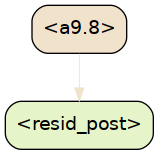

1 --------------------------------------------------
No edge 22363
22363
No edge 22363
New metric: 0.09159860759973526

Node: cur_parent=TLACDCInterpNode(blocks.9.hook_v_input, [:, :, 8]) (self.current_node=TLACDCInterpNode(blocks.9.attn.hook_v, [:, :, 8]))

Metric after removing connection to blocks.9.hook_v_input [:, :, 8] is 0.2919684648513794 (and current metric 0.09159860759973526)
Result is 0.20036985725164413...so keeping connection
No edge 22363
We moved to  blocks.9.attn.hook_v[:, :, 7]
No edge 22363
No edge 22362
But it's bad
We moved to  blocks.9.attn.hook_v[:, :, 6]
No edge 22362
No edge 22361
But it's bad
We moved to  blocks.9.attn.hook_v[:, :, 5]
No edge 22361
No edge 22360
But it's bad
We moved to  blocks.9.attn.hook_v[:, :, 4]
No edge 22360
No edge 22359
But it's bad
We moved to  blocks.9.attn.hook_v[:, :, 3]
No edge 22359
No edge 22358
But it's bad
We moved to  blocks.9.attn.hook_v[:, :, 2]
No edge 22358
No edge 22357
But it's bad
We moved to  blocks.9.attn.hook_v[:, :

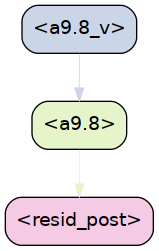

2 --------------------------------------------------
No edge 22352
22352
No edge 22352
New metric: 0.09159860759973526

Node: cur_parent=TLACDCInterpNode(blocks.9.hook_k_input, [:, :, 8]) (self.current_node=TLACDCInterpNode(blocks.9.attn.hook_k, [:, :, 8]))

Metric after removing connection to blocks.9.hook_k_input [:, :, 8] is 0.22556278109550476 (and current metric 0.09159860759973526)
Result is 0.1339641734957695...so keeping connection
No edge 22352
We moved to  blocks.9.attn.hook_k[:, :, 7]
No edge 22352
No edge 22351
But it's bad
We moved to  blocks.9.attn.hook_k[:, :, 6]
No edge 22351
No edge 22350
But it's bad
We moved to  blocks.9.attn.hook_k[:, :, 5]
No edge 22350
No edge 22349
But it's bad
We moved to  blocks.9.attn.hook_k[:, :, 4]
No edge 22349
No edge 22348
But it's bad
We moved to  blocks.9.attn.hook_k[:, :, 3]
No edge 22348
No edge 22347
But it's bad
We moved to  blocks.9.attn.hook_k[:, :, 2]
No edge 22347
No edge 22346
But it's bad
We moved to  blocks.9.attn.hook_k[:, :

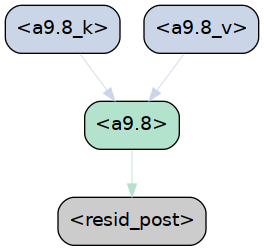

3 --------------------------------------------------
No edge 22341
22341
No edge 22341
New metric: 0.09159860759973526

Node: cur_parent=TLACDCInterpNode(blocks.9.hook_q_input, [:, :, 8]) (self.current_node=TLACDCInterpNode(blocks.9.attn.hook_q, [:, :, 8]))

Metric after removing connection to blocks.9.hook_q_input [:, :, 8] is 0.2845578193664551 (and current metric 0.09159860759973526)
Result is 0.19295921176671982...so keeping connection
No edge 22341
We moved to  blocks.9.attn.hook_q[:, :, 7]
No edge 22341
No edge 22340
But it's bad
We moved to  blocks.9.attn.hook_q[:, :, 6]
No edge 22340
No edge 22339
But it's bad
We moved to  blocks.9.attn.hook_q[:, :, 5]
No edge 22339
No edge 22338
But it's bad
We moved to  blocks.9.attn.hook_q[:, :, 4]
No edge 22338
No edge 22337
But it's bad
We moved to  blocks.9.attn.hook_q[:, :, 3]
No edge 22337
No edge 22336
But it's bad
We moved to  blocks.9.attn.hook_q[:, :, 2]
No edge 22336
No edge 22335
But it's bad
We moved to  blocks.9.attn.hook_q[:, :

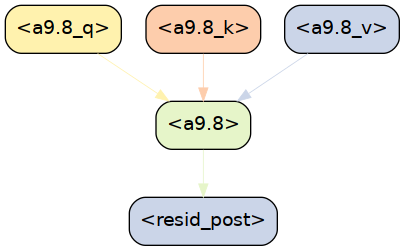

4 --------------------------------------------------
No edge 21979
21979
No edge 21979
New metric: 0.09159860759973526

Node: cur_parent=TLACDCInterpNode(blocks.8.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.9.hook_v_input, [:, :, 8]))

Metric after removing connection to blocks.8.hook_mlp_out [:] is 0.08136427402496338 (and current metric 0.09159860759973526)
Result is -0.010234333574771881...so removing connection
No edge 21978

Node: cur_parent=TLACDCInterpNode(blocks.8.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.9.hook_v_input, [:, :, 8]))

Metric after removing connection to blocks.8.attn.hook_result [:, :, 0] is 0.0754653811454773 (and current metric 0.08136427402496338)
Result is -0.005898892879486084...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.8.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.9.hook_v_input, [:, :, 8]))

Metric after removing connection to blocks.8.attn.hook_result [:, :

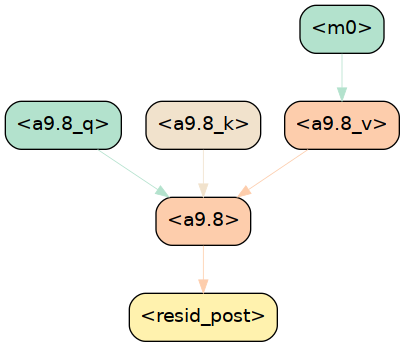

5 --------------------------------------------------
No edge 20564
20564
No edge 20564
New metric: 0.20741982758045197

Node: cur_parent=TLACDCInterpNode(blocks.8.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.9.hook_k_input, [:, :, 8]))

Metric after removing connection to blocks.8.hook_mlp_out [:] is 0.1782965064048767 (and current metric 0.20741982758045197)
Result is -0.029123321175575256...so removing connection
No edge 20563

Node: cur_parent=TLACDCInterpNode(blocks.8.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.9.hook_k_input, [:, :, 8]))

Metric after removing connection to blocks.8.attn.hook_result [:, :, 0] is 0.1750633716583252 (and current metric 0.1782965064048767)
Result is -0.0032331347465515137...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.8.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.9.hook_k_input, [:, :, 8]))

Metric after removing connection to blocks.8.attn.hook_result [:, :,

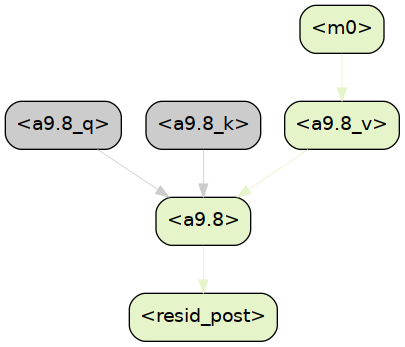

6 --------------------------------------------------
No edge 19148
19148
No edge 19148
New metric: 0.2797100841999054

Node: cur_parent=TLACDCInterpNode(blocks.8.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.9.hook_q_input, [:, :, 8]))

Metric after removing connection to blocks.8.hook_mlp_out [:] is 0.2797100841999054 (and current metric 0.2797100841999054)
Result is 0.0...so removing connection
No edge 19147

Node: cur_parent=TLACDCInterpNode(blocks.8.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.9.hook_q_input, [:, :, 8]))

Metric after removing connection to blocks.8.attn.hook_result [:, :, 0] is 0.2797100841999054 (and current metric 0.2797100841999054)
Result is 0.0...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.8.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.9.hook_q_input, [:, :, 8]))

Metric after removing connection to blocks.8.attn.hook_result [:, :, 1] is 0.2797100841999054 (and current 

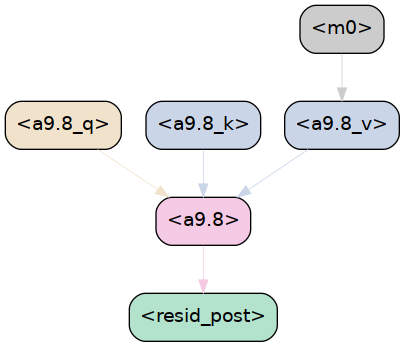

7 --------------------------------------------------
No edge 90
90
No edge 90
New metric: 0.2797100841999054
No edge 90
We moved to  blocks.0.hook_mlp_in[:]
No edge 90


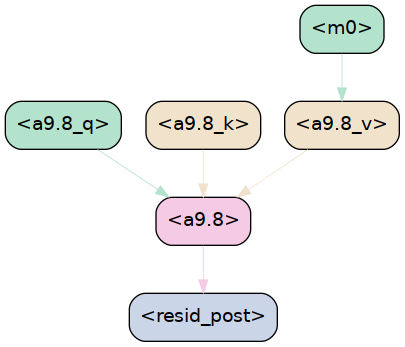

8 --------------------------------------------------
No edge 90
90
No edge 90
New metric: 0.2797100841999054

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.0.hook_mlp_in, [:]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 0] is 0.2812770903110504 (and current metric 0.2797100841999054)
Result is 0.0015670061111450195...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.0.hook_mlp_in, [:]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 1] is 0.2856709659099579 (and current metric 0.2812770903110504)
Result is 0.004393875598907471...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 2]) (self.current_node=TLACDCInterpNode(blocks.0.hook_mlp_in, [:]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 2] is 0.2907436490058899 (a

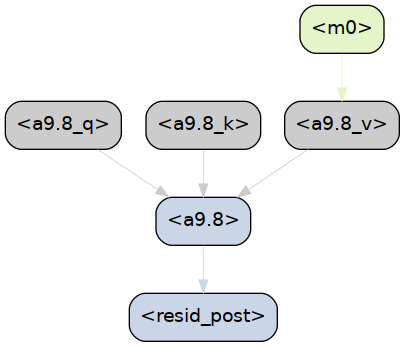

9 --------------------------------------------------
No edge 5
5
No edge 5
New metric: 0.2804564833641052
We moved to  None
No edge 5


/newdisk3/yunzhi/Knowledge-Circuit/notebook/../acdc/TLACDCExperiment.py:772: UserWarning: Finished iterating
  warnings.warn("Finished iterating")


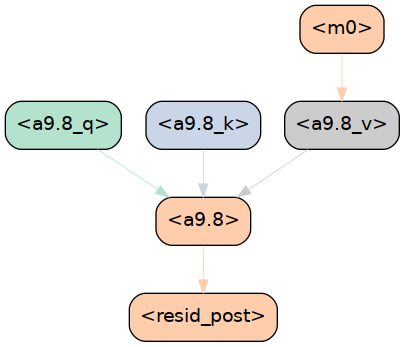

10 --------------------------------------------------
No edge 5
5


In [9]:
for i in range(args.max_num_epochs):
    exp.step(testing=False)

    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=False,
    )

    
    display(Image(f"ims/img_new_{i+1}.png"))

    print(i, "-" * 50)
    print(exp.count_no_edges())

    if i == 0:
        exp.save_edges("edges.pkl")

    if exp.current_node is None or SINGLE_STEP:
        break

exp.save_edges("another_final_edges.pkl")

if USING_WANDB:
    edges_fname = f"edges.pth"
    exp.save_edges(edges_fname)
    artifact = wandb.Artifact(edges_fname, type="dataset")
    artifact.add_file(edges_fname)
    wandb.log_artifact(artifact)
    os.remove(edges_fname)
    wandb.finish()